<a href="https://colab.research.google.com/github/IshikaSaxena2005/AI-Powered-Education-Insights-Platform/blob/main/course_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
folder_path = '/content/drive/My Drive/coursera/'

In [3]:
import os
os.listdir(folder_path)

['reviews_by_course.csv', 'reviews.csv']

In [4]:
import pandas as pd


reviews_df = os.path.join(folder_path, 'reviews.csv')
reviews_by_course_df= os.path.join(folder_path, 'reviews_by_course.csv')


general_reviews = pd.read_csv(reviews_df)
course_reviews= pd.read_csv(reviews_by_course_df)


In [5]:
print(general_reviews.head())
print(course_reviews.head())

   Id                                             Review  Label
0   0                               good and interesting      5
1   1  This class is very helpful to me. Currently, I...      5
2   2  like!Prof and TAs are helpful and the discussi...      5
3   3  Easy to follow and includes a lot basic and im...      5
4   4  Really nice teacher!I could got the point eazl...      4
     CourseId                                             Review  Label
0  2-speed-it                                             BOring      1
1  2-speed-it                                            Bravo !      5
2  2-speed-it                                           Very goo      5
3  2-speed-it  Great course - I recommend it for all, especia...      5
4  2-speed-it    One of the most useful course on IT Management!      5


for reviews_df:
id:unique if for each review

review: text of the revies provided by users

label:a rating( 1to 5)



for reviews_by_course_df:

courseid: identifier for the course

review:Text of the review

label: a rating for the course

preprocessing

SENTIMENT PREDICTION

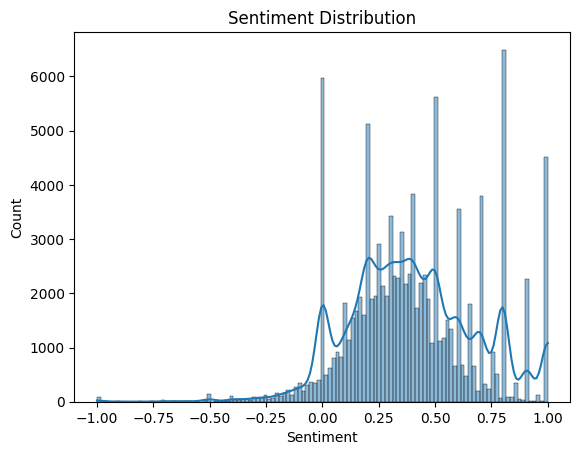

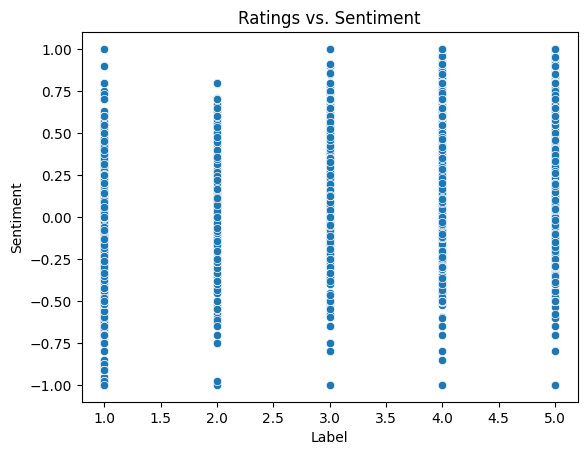

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(general_reviews['Sentiment'], kde=True)
plt.title('Sentiment Distribution')
plt.show()


sns.scatterplot(data=general_reviews, x='Label', y='Sentiment')
plt.title('Ratings vs. Sentiment')
plt.show()


In [16]:
!pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 8.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357280 sha256=bbcdc63a5dcce5c5b7ca09ba00c5a99000b1756f0d59d2f3ddd05ed89937650f
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


COURSE RECOMMENDATION


In [26]:
import pandas as pd

course_reviews['UserId'] = ["user_" + str(i) for i in range(len(course_reviews))]


print(course_reviews)


   CourseId        Review  Label  UserId
0  course_1   Good course      5  user_0
1  course_2       Amazing      4  user_1
2  course_1  Very helpful      5  user_2
3  course_3   Informative      3  user_3
4  course_2        Boring      2  user_4


In [19]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

# Prepare data for the surprise library
reader = Reader(rating_scale=(1, 5))  # Assuming ratings are from 1 to 5
data = Dataset.load_from_df(course_reviews[["UserId", "CourseId", "Label"]], reader)

# Split the dataset into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)


In [20]:
from surprise import SVD
from surprise import accuracy

# Train the SVD model
model = SVD()
model.fit(trainset)

# Make predictions on the test set
predictions = model.test(testset)

# Evaluate the model's accuracy
rmse = accuracy.rmse(predictions)
print(f"Root Mean Square Error (RMSE): {rmse}")


RMSE: 1.3515
Root Mean Square Error (RMSE): 1.3515236547556695


COURSE RATING

In [23]:
import pandas as pd

# Example user
user_id = "user_0"

# List all unique Course IDs
all_courses = course_reviews['CourseId'].unique()

# Get courses already rated by the user
user_courses = course_reviews[course_reviews["UserId"] == user_id]["CourseId"].tolist()

# Predict ratings for unseen courses
recommendations = []
for course_id in all_courses:
    if course_id not in user_courses:  # Skip already rated courses
        pred = model.predict(user_id, course_id)
        recommendations.append((course_id, pred.est))  # Store course and predicted rating

# Sort recommendations by predicted rating (descending)
recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)

# Convert recommendations to a DataFrame for better display
recommendations_table = pd.DataFrame(recommendations, columns=["Course ID", "Predicted Rating"])
print(recommendations_table)


  Course ID  Predicted Rating
0  course_3          3.452694
1  course_2          3.414441


COURSE POPULARITY

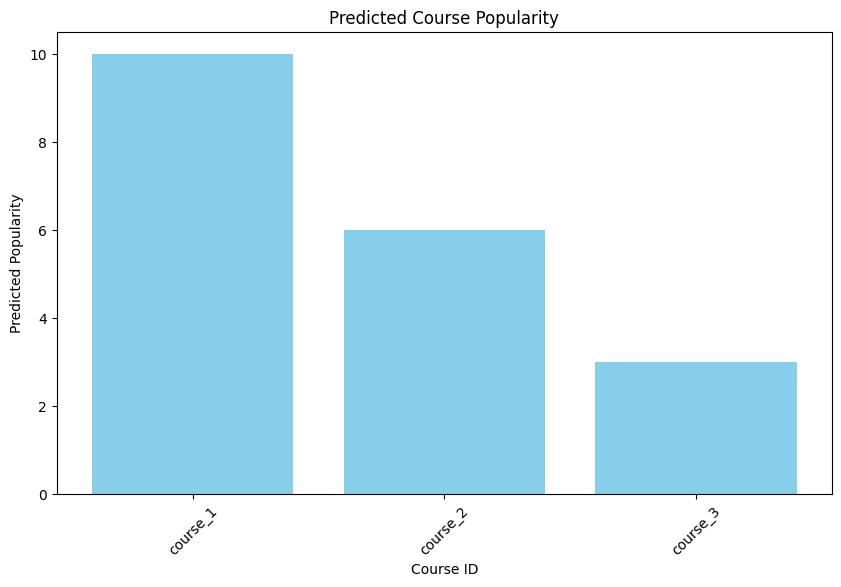

   CourseId  predicted_popularity
0  course_1                  10.0
1  course_2                   6.0
2  course_3                   3.0


In [25]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

popularity_data = course_reviews.groupby('CourseId').agg(
    num_reviews=('Review', 'count'),
    avg_rating=('Label', 'mean')
).reset_index()

popularity_data['popularity'] = popularity_data['num_reviews'] * popularity_data['avg_rating']


X = popularity_data[['num_reviews', 'avg_rating']]
y = popularity_data['popularity']


model = LinearRegression()
model.fit(X, y)


popularity_data['predicted_popularity'] = model.predict(X)


plt.figure(figsize=(10, 6))
plt.bar(popularity_data['CourseId'], popularity_data['predicted_popularity'], color='skyblue')
plt.title('Predicted Course Popularity')
plt.xlabel('Course ID')
plt.ylabel('Predicted Popularity')
plt.xticks(rotation=45)
plt.show()


print(popularity_data[['CourseId', 'predicted_popularity']])


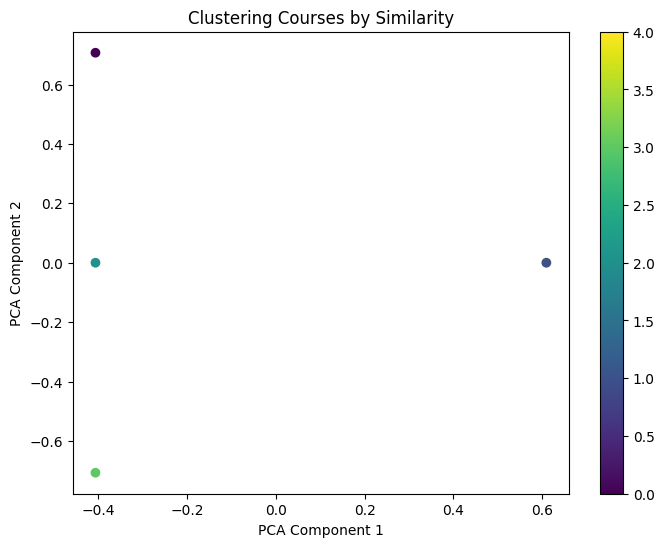

In [32]:

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

course_descriptions = course_reviews['Review'].dropna()


vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(course_descriptions)


kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(tfidf_matrix)


course_reviews['Cluster'] = kmeans.labels_


pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=course_reviews['Cluster'], cmap='viridis')
plt.title('Clustering Courses by Similarity')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()


In [33]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.5 MB/s eta 0:00:00


In [37]:
def load_data():
  folder_path='/content/drive/My Drive/coursera/'
  reviews_df = os.path.join(folder_path, 'reviews.csv')
  reviews_by_course_df= os.path.join(folder_path, 'reviews_by_course.csv')
  general_reviews = pd.read_csv(reviews_df)
  course_reviews= pd.read_csv(reviews_by_course_df)
  return general_reviews,course_reviews




In [53]:
def analyze_sentiment():
    general_reviews['Sentiment'] = general_reviews['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
    course_reviews['Sentiment'] = course_reviews['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
    print(general_reviews[['Review', 'Sentiment']].head())
    print(course_reviews[['Review', 'Sentiment']].head())
    return general_reviews,course_reviews

In [40]:
course_reviews['UserId']=["user_"+str(i) for i in range(len(course_reviews))]

def get_recommendations(user_id,course_reviews,model):
   all_courses = course_reviews['CourseId'].unique()
   user_courses = course_reviews[course_reviews["UserId"] == user_id]["CourseId"].tolist()

   recommendations = []
   for course_id in all_courses:
    if course_id not in user_courses:
      # Skip already rated courses
      pred = model.predict(user_id, course_id)
      recommendations.append((course_id, pred.est))  # Store course and predicted rating

    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)
    return pd.DataFrame(recommendations, columns=["Course ID", "Predicted Rating"])

In [41]:
def predict_popularity(course_reviews):
    # Group by CourseId to calculate the number of reviews and average rating
    popularity_data = course_reviews.groupby('CourseId').agg(
        num_reviews=('Review', 'count'),
        avg_rating=('Label', 'mean')
    ).reset_index()
    # Define popularity based on the number of reviews and average rating
    popularity_data['popularity'] = popularity_data['num_reviews'] * popularity_data['avg_rating']

    # Prepare data for linear regression
    X = popularity_data[['num_reviews', 'avg_rating']]
    y = popularity_data['popularity']

    # Train the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Predict popularity
    popularity_data['predicted_popularity'] = model.predict(X)
    return popularity_data[['CourseId', 'predicted_popularity']]